In [1]:
# ==============================================================================
# ÉTAPE 1 : IMPORTATION ET CONFIGURATION DE L'ENVIRONNEMENT
# ==============================================================================

# --- Gestion du Système et Alertes ---
import os                        # Gérer les chemins, répertoires et fichiers
if os.path.exists("model_lstm_new.h5"):
    os.remove("model_lstm_new.h5")
if os.path.exists("tokenizer_keras.pickle"):
    os.remove("tokenizer_keras.pickle")

import warnings                  # Gestion des messages d'alerte
warnings.filterwarnings('ignore') # Masquer les warnings pour un affichage propre

# --- Manipulation et Analyse de Données ---
import pandas as pd              # Lecture et manipulation des DataFrames
import numpy as np               # Opérations numériques et gestion des tableaux

# --- Visualisation de Données ---
import matplotlib.pyplot as plt  # Création de graphiques de base
import seaborn as sns            # Visualisation statistique avancée (Matrice de confusion)

# Affichage
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Imports généraux chargés")


✅ Imports généraux chargés


# CHARGEMENT DU CORPUS (BBC NEWS)

In [2]:
# NLP classique
import re
import spacy
import nltk
from nltk.corpus import stopwords


# Chargement du modèle linguistique SpaCy
nlp = spacy.load("en_core_web_sm")


print("✅ NLP classique prêt")


✅ NLP classique prêt


In [3]:
import zipfile


def charger_corpus_bbc(chemin_zip, limite_par_cat=150):
    donnees = []
    categories = ['business', 'entertainment', 'tech']
    compteur = {cat: 0 for cat in categories}


    with zipfile.ZipFile(chemin_zip, 'r') as z:
        for info in z.infolist():
            parts = info.filename.split('/')
            if info.filename.endswith('.txt') and len(parts) > 1:
                cat = parts[-2]
                if cat in categories and compteur[cat] < limite_par_cat:
                    with z.open(info.filename) as f:
                        texte = f.read().decode('latin-1')
                        donnees.append({
                            'Thématique': cat,
                            'Texte_Brut': texte
                        })
                        compteur[cat] += 1
            if all(compteur[c] >= limite_par_cat for c in categories):
                break


    df = pd.DataFrame(donnees)
    print("\nDistribution des classes :")
    print(df['Thématique'].value_counts())
    return df


df_bbc = charger_corpus_bbc('bbc-fulltext.zip')

df_bbc.head()



Distribution des classes :
Thématique
business         150
entertainment    150
tech             150
Name: count, dtype: int64


,Thématique,Texte_Brut
0,business,Ad sales boost Time Warner profit\n\nQuarterly...
1,business,Dollar gains on Greenspan speech\n\nThe dollar...
2,business,Yukos unit buyer faces loan claim\n\nThe owner...
3,business,High fuel prices hit BA's profits\n\nBritish A...
4,business,Pernod takeover talk lifts Domecq\n\nShares in...


# Nettoyage & lemmatisation 

In [4]:
# ⚠️ IMPORTANT : ce texte nettoyé est utilisé pour LSTM / Word2Vec
# ⚠️ Le texte BRUT sera utilisé pour BERT / DistilBERT


def pipeline_nlp(texte):
    texte = re.sub(r'https?://\S+|www\.\S+', '', texte)
    texte = re.sub(r'<.*?>', '', texte)
    texte = re.sub(r'[^a-zA-Z\s]', ' ', texte)
    texte = re.sub(r'\s+', ' ', texte).strip()

    doc = nlp(texte)

    tokens = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and not token.is_punct and not token.is_space
    ]

    analyse = [
        {'mot': t.text, 'pos': t.pos_, 'dep': t.dep_}
        for t in doc if not t.is_space
    ]

    return " ".join(tokens), analyse

df_bbc['Texte_Nettoye'], df_bbc['Analyse_Syntaxique'] = zip(*df_bbc['Texte_Brut'].apply(pipeline_nlp))
df_bbc.head()


,Thématique,Texte_Brut,Texte_Nettoye,Analyse_Syntaxique
0,business,Ad sales boost Time Warner profit\n\nQuarterly...,ad sale boost time warner profit quarterly pro...,"[{'mot': 'Ad', 'pos': 'NOUN', 'dep': 'compound..."
1,business,Dollar gains on Greenspan speech\n\nThe dollar...,dollar gain greenspan speech dollar hit high l...,"[{'mot': 'Dollar', 'pos': 'NOUN', 'dep': 'comp..."
2,business,Yukos unit buyer faces loan claim\n\nThe owner...,yukos unit buyer face loan claim owner embattl...,"[{'mot': 'Yukos', 'pos': 'PROPN', 'dep': 'comp..."
3,business,High fuel prices hit BA's profits\n\nBritish A...,high fuel price hit ba s profit british airway...,"[{'mot': 'High', 'pos': 'ADJ', 'dep': 'amod'},..."
4,business,Pernod takeover talk lifts Domecq\n\nShares in...,pernod takeover talk lift domecq shares uk dri...,"[{'mot': 'Pernod', 'pos': 'NOUN', 'dep': 'comp..."


# WORD2VEC & EMBEDDINGS DE DOCUMENTS

In [5]:

from gensim.models import Word2Vec

sentences = [txt.split() for txt in df_bbc['Texte_Nettoye']]

model_w2v = Word2Vec(
sentences,
vector_size=100,
window=5,
min_count=2,
workers=4
)

print("Taille vocabulaire Word2Vec :", len(model_w2v.wv))

# Vecteur de document = moyenne des vecteurs de mots
def document_vector(tokens, model):
    mots = [w for w in tokens if w in model.wv]
    if not mots:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[mots], axis=0)

df_bbc['Doc_Vector'] = df_bbc['Texte_Nettoye'].apply(lambda x: document_vector(x.split(), model_w2v))


Taille vocabulaire Word2Vec : 6118


# VISUALISATION PCA

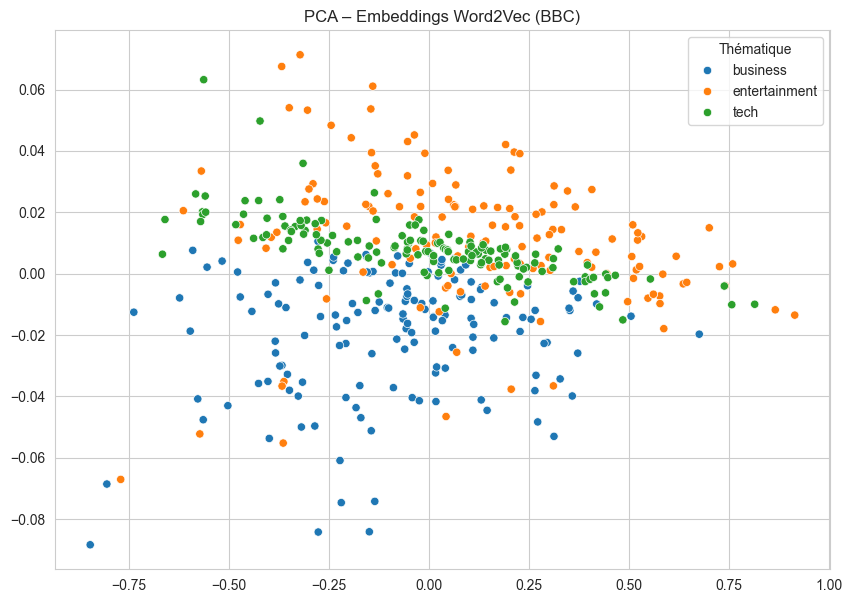

In [6]:
from sklearn.decomposition import PCA
X_vec = np.stack(df_bbc['Doc_Vector'].values)
y_cat = df_bbc['Thématique']

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_vec)

plt.figure(figsize=(10,7))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_cat)
plt.title("PCA – Embeddings Word2Vec (BBC)")
plt.show()

# PRÉPARATION DES DONNÉES (LSTM)

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_words = 5000
max_len = 200
tokenizer_keras = Tokenizer(num_words=max_words)
tokenizer_keras.fit_on_texts(df_bbc['Texte_Nettoye'])
sequences = tokenizer_keras.texts_to_sequences(df_bbc['Texte_Nettoye'])
X_seq = pad_sequences(sequences, maxlen=max_len)


# Encodage labels

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_bbc['target'] = le.fit_transform(df_bbc['Thématique'])
y = df_bbc['target'].values

In [9]:
# --- Sauvegarde tokenizer ---
import pickle
with open('tokenizer_keras.pickle', 'wb') as f:
    pickle.dump(tokenizer_keras, f)

print("✅ Prétraitement terminé, tokenizer sauvegardé")

✅ Prétraitement terminé, tokenizer sauvegardé
